# 패키지 불러오기

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

# 사진 준비

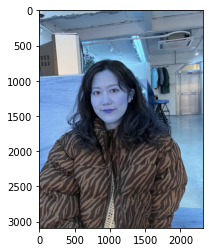

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/IMG_1571.JPG'
img_bgr = cv2.imread(my_image_path)
img_show = img_bgr.copy()
plt.imshow(img_bgr)
plt.show()

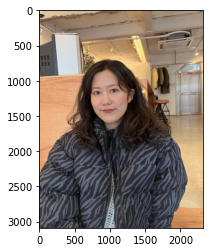

In [3]:
# BGR -> RGB
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# 얼굴 검출 with HOG&SVM

<function matplotlib.pyplot.show(close=None, block=None)>

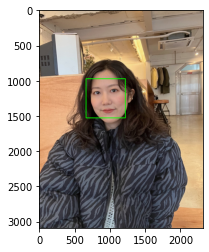

In [4]:
# detector_hog 이용해서 얼굴 bounding box 추출
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb,1)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show,(l,t),(r,b),(0,255,0),10,lineType=cv2.LINE_AA)
    #cv2.rectangle(img,시작점좌표,종료점좌표,색상,선 두께, 선 종류)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show

- dlib detector는 dlib.rectangles 타입의 객체 반환
- dlib.retangles는 dlib.rectangle 객체의 배열 형태로 이루어짐
- dlib.rectangle 객체는 left(), top(), right(), bottom(), height(), width() 등의 멤버 함수 포함

# 얼굴 랜드마크

In [5]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb,dlib_rect) # rgb 이미지와 dlib_rect을 받아 dlib.full_object_detection 반환
    # face landmark 좌표를 저장
    list_points = list(map(lambda p:(p.x,p.y),points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


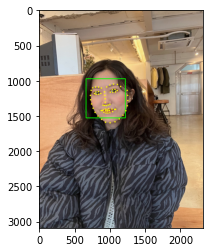

In [6]:
# 랜드마크 출력
# 랜드마크 출력해보기
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point,10, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


# 스티커 적용하기

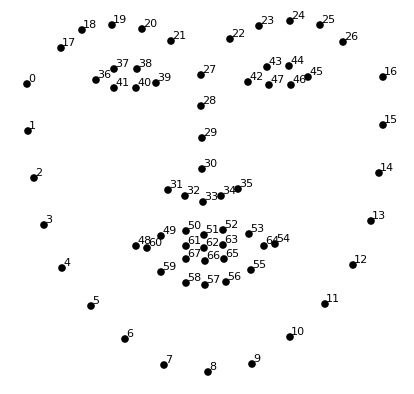

- 위에는 **Dlib에 사용 되는 랜드마크 순서** 나타냄
- 번호에 맞게 스티커 위치 지정하기

In [7]:
# 좌표 확인해서 스티커 위치 지정하기
for dlib_rect, landmark in zip(dlib_rects,list_landmarks):
    print(landmark[29])
    x = landmark[29][0]
    y = landmark[29][1]
    w = h = dlib_rect.width()
    print('(x,y) : (%d,%d)'%(x,y))
    print('(w,h) : (%d,%d)'%(w,h))

(933, 1257)
(x,y) : (933,1257)
(w,h) : (556,556)


In [8]:
# 준비한 스티커 적용하기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
''' 
- 스티커 뒤에 흰색 배경 나오는거 없앨려고 작성한 코드 -
But, 채널 4개 되서 밑에 에러생겨서 못씀
# 배경 오려내기
# 1. 알파채널 이용해서 마스크와 역마스크 생성
_, mask = cv2.threshold(img_sticker[:,:,3], 1, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask)

# 2. 마스크 이용해서 오려내기
masked_fg = cv2.bitwise_and(img_sticker, img_sticker,mask=mask)

plt.imshow(masked_fg)
plt.show()


# 3. 오려낸 이미지 저장하기
cv2.imwrite('cat_final.png',img_sticker)'''

(556, 556, 3)


" \n- 스티커 뒤에 흰색 배경 나오는거 없앨려고 작성한 코드 -\nBut, 채널 4개 되서 밑에 에러생겨서 못씀\n# 배경 오려내기\n# 1. 알파채널 이용해서 마스크와 역마스크 생성\n_, mask = cv2.threshold(img_sticker[:,:,3], 1, 255, cv2.THRESH_BINARY)\nmask_inv = cv2.bitwise_not(mask)\n\n# 2. 마스크 이용해서 오려내기\nmasked_fg = cv2.bitwise_and(img_sticker, img_sticker,mask=mask)\n\nplt.imshow(masked_fg)\nplt.show()\n\n\n# 3. 오려낸 이미지 저장하기\ncv2.imwrite('cat_final.png',img_sticker)"

In [9]:
# 원본 이미지에 스티커 이미지 추가 위해 x,y좌표 조정
refined_x = x - w // 2
refined_y = y - h // 2

if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0
    
print ('(x,y) : (%d,%d)'%(refined_x, refined_y)) # 얼굴 자신 영역 벗어나면 음수로 표현

(x,y) : (655,979)


In [10]:
# 원본 이미지에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0],
                       refined_x:refined_x+img_sticker.shape[1]]
# img_show[]=np.where()
img_show[refined_y:refined_y+img_sticker.shape[0], 
         refined_x:refined_x+img_sticker.shape[1]  
        ] = \
        np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)
        # 3항 연산자 np.where(조건,a,b)
        # 해당 지점이 투명이면 sticker_area는 True, img_sticker는 False
print('Done!!')

Done!!


- **np.where()** : 조건문 사용할때 사용. 인덱스 반환. 슬라이싱에 사용가능

In [11]:
'''img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)'''

'img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)'

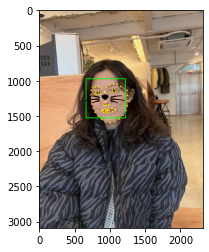

In [12]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 원본 이미지에 최종 결과 출력

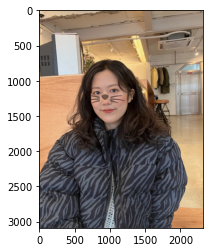

In [13]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area,0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8),0.5,0)
                                        # 255인거 찾아서 스티커 area로 바꾸고 아닌것은 img_sticker
                                        # ( 조건식,  True, False)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

- **cv2.addWeighted()** 로 스티커 이미지에 자연스럽게 블렌딩

# + 얼굴 각도가 다른 이미지에 적용해본다면?

#### - 얼굴 각도가 옆으로 변하니까 스티커 사진도 회전해야 더 자연스럽게 블렌딩 가능
#### - cv2.getRotationMatrix2D() 로 변환행렬 구해서 이미지 회전시키기

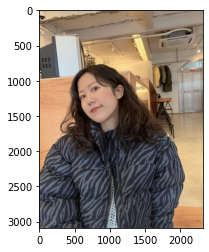

In [14]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/IMG_1570.JPG'
img_bgr = cv2.imread(my_image_path)
img_show = img_bgr.copy()

# BGR -> RGB
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

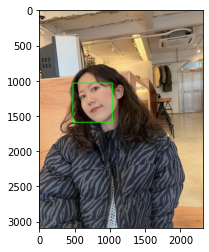

In [15]:
# detector_hog 이용해서 얼굴 bounding box 추출
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb,1)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show,(l,t),(r,b),(0,255,0),10,lineType=cv2.LINE_AA)
    #cv2.rectangle(img,시작점좌표,종료점좌표,색상,선 두께, 선 종류)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show

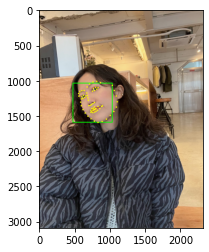

In [16]:
# 얼굴 랜드마크
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb,dlib_rect) # rgb 이미지와 dlib_rect을 받아 dlib.full_object_detection 반환
    # face landmark 좌표를 저장
    list_points = list(map(lambda p:(p.x,p.y),points.parts()))
    list_landmarks.append(list_points)
    
# 랜드마크 출력
# 랜드마크 출력해보기
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point,10, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

(682, 1211)
(x,y) : (682,1211)
(w,h) : (556,556)


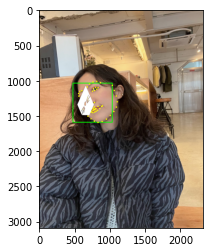

In [17]:
# 좌표 확인해서 스티커 위치 지정하기
for dlib_rect, landmark in zip(dlib_rects,list_landmarks):
    print(landmark[28])
    x = landmark[28][0]
    y = landmark[28][1]
    w = h = dlib_rect.width()
    print('(x,y) : (%d,%d)'%(x,y))
    print('(w,h) : (%d,%d)'%(w,h))
# 스티커 가져오기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))


# 원본 이미지에 스티커 이미지 추가 위해 x,y좌표 조정
refined_x = x - w // 2
refined_y = y - h // 2


if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

# OpenCV로 회전 변환행렬 구하기
# 1. 회전 위한 변환 행렬 구하기
# 회전축:중앙, 각도:30, 배율:0.5
m30 = cv2.getRotationMatrix2D((refined_y/2,refined_x/2),30,0.5)
# 회전축:중앙, 각도:45, 배율:0.3
m45 = cv2.getRotationMatrix2D((refined_y/2,refined_x/2),45,0.5)

# 2. 변환 행렬 적용
img30 = cv2.warpAffine(img_sticker, m30,(refined_y,refined_x))
img45 = cv2.warpAffine(img_sticker, m45,(refined_y,refined_x))
img45 = cv2.resize(img45, (w,h))


# 원본 이미지에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0],
                       refined_x:refined_x+img_sticker.shape[1]]
# img_show[]=np.where()
img_show[refined_y:refined_y+img_sticker.shape[0], 
         refined_x:refined_x+img_sticker.shape[1]  
        ] = \
        np.where(img45==0,sticker_area,img45).astype(np.uint8)
        # 3항 연산자 np.where(조건,a,b)
        # 해당 지점이 투명이면 sticker_area는 True, img_sticker는 False

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()


## OpenCV로 회전 변환행렬 구하기

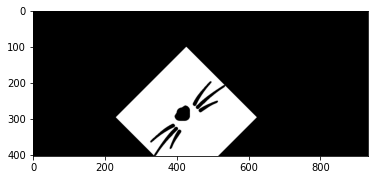

In [18]:
# 1. 회전 위한 변환 행렬 구하기
# 회전축:중앙, 각도:30, 배율:0.5
m30 = cv2.getRotationMatrix2D((refined_y/2,refined_x/2),30,0.5)
# 회전축:중앙, 각도:45, 배율:1
m45 = cv2.getRotationMatrix2D((refined_y/2,refined_x/2),45,0.5)

# 2. 변환 행렬 적용
img30 = cv2.warpAffine(img_sticker, m30,(refined_y,refined_x))
img45 = cv2.warpAffine(img_sticker, m45,(refined_y,refined_x))

# 3. 결과 출력
# plt.imshow(img_sticker)
# plt.show
# plt.imshow(img30)
# plt.show
plt.imshow(img45)
plt.show
cv2.waitKey(0)
cv2.destroyAllWindows()

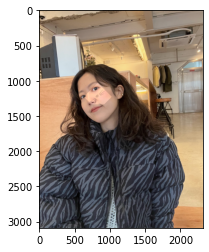

In [19]:
# 원본 이미지에 스티커 추가
sticker_area = img_bgr[refined_y:refined_y +img45.shape[0], refined_x:refined_x+img45.shape[1]]
img_bgr[refined_y:refined_y +img45.shape[0], refined_x:refined_x+img45.shape[1]] = \
    cv2.addWeighted(sticker_area,1, np.where(img45==0,img45,sticker_area).astype(np.uint8),0.2,0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 회고
- 스티커를 회전하여 추가하면 될줄 알았으나 각도도 변경해야하는 문제점 있음.
-다음엔 기준 각도를 포함해서 보완해볼것!

In [20]:
# 기준 각도 -> 다음에 적용해보기

# dy = landmarks[29][1] - landmarks[27][1]
# dx = landmarks[29][0] - landmarks[27][0]

# angle = math.atan(dy/dx)

# # Radian을 Degree로 변경하기
# # 1 radian = 180 / PI = 57.295779513082323°

# angle = angle * 180/ math.pi

# if angle > 0: # 90도 기준
#     rot_angle = 90 - angle  # 90도 - 현재 각도 = 돌려진 각도
# else:
#     rot_angle = -90 - angle 